In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow_probability as tfp

In [3]:
import numpy as np
from pathlib import Path

In [4]:
import os

import matplotlib
import matplotlib.pyplot as plt

In [6]:
import vae

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Setup

## Hyperparameters

Architecture hyperparameters:

In [8]:
LAT_DIM = 256
GEN_KERNELS = [4, 4, 4, 4]
INF_KERNELS = [4, 4, 4]

Training hyperparameters:

In [9]:
BETA_1 = 0.5
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 10

In [10]:
PLOT_DIR = Path(os.path.expandvars("$HOME")) / 'vae-paper' / 'figures'
PLOT_DIR.mkdir(exist_ok=True, parents=True)

Setup checkpointing:

In [11]:
CHKPT_NAME = "default"

## Setup default I/O directory to scratch

In [12]:
DIR = Path(os.path.expandvars("$SCRATCH")) / "dustvaeder"
%ls $DIR

I_GNILC_DATASET.cdf              semantic_sequence_dataset.npy
checkpoint                       test_predicted.npy
data_imputation_dataset.npy      tflogs/
datasets/                        train_predicted.npy
models/                          trained_vae.data-00000-of-00002
novel_samples.npy                trained_vae.data-00001-of-00002
plots/                           trained_vae.index
reconstructed_w_res_dataset.npy  training_dataset.npy
results/


## Setup training data

Reshape to $(n_{\rm batch}, x, y, n_{\rm channels})$, apply log transform, and export as numpy array with type float32.

In [13]:
GNILC_arr = np.load(DIR / "training_dataset.npy")

### Normalization

To normalize the data we first apply a log to the data, whilst still in units of MJy / sr. We then standardize each image to a normal distribution.

$$
\mathbf{x}_i = \frac{\left(\log[I_i] - {\rm mean}(\log[I_i])\right)}{{\rm std}(\log[I_i])} 
$$

We also apply:

- Shuffle
- Per image standardization to a normal distribution

We then split up the dataset into a 15% validation ste, 15% test set and 70% training set.

After the test / train / val split, we apply the batching and prefetch operators to the training data.

In [14]:
print(GNILC_arr.shape)
DATASET_SIZE = GNILC_arr.shape[0]

(2261, 256, 256, 1)


In [15]:
def split_data(numpy_dataset, train_size, val_size, test_size, batch_size, seed=1234):
    buffer_size = numpy_dataset.shape[0]
    assert train_size + val_size + test_size == 1
    train_size = int(0.7 * buffer_size)
    val_size = int(0.15 * buffer_size)
    test_size = int(0.15 * buffer_size)
    dataset = tf.data.Dataset.from_tensor_slices(numpy_dataset).map(tf.image.per_image_standardization)
    full_dataset = dataset.shuffle(buffer_size, seed=seed)
    train = full_dataset.take(train_size).batch(batch_size, drop_remainder=True)
    test = full_dataset.skip(train_size)
    val = test.skip(val_size).batch(batch_size).prefetch(1)
    test = test.take(test_size).batch(batch_size).prefetch(1)
    return train, val, test

train_dataset, val_dataset, test_dataset = split_data(GNILC_arr, 0.7, 0.15, 0.15, BATCH_SIZE)

In [17]:
from cvae import setup_vae_run_logging, tb_address

In [18]:
TF_LOGDIR = DIR / "tflogs"
%env TF_LOGDIR=$TF_LOGDIR
summary_writer = setup_vae_run_logging(CHKPT_NAME)

env: TF_LOGDIR=/global/cscratch1/sd/bthorne/dustvaeder/tflogs


In [19]:
%load_ext tensorboard

In [20]:
%env TENSORBOARD_BINARY=/global/homes/b/bthorne/projects/DustVAEder/env/bin/tensorboard
%tensorboard --logdir $DIR/tflogs --port 0
tb_address()


env: TENSORBOARD_BINARY=/global/homes/b/bthorne/projects/DustVAEder/env/bin/tensorboard


ERROR: Could not find
'/global/homes/b/bthorne/projects/DustVAEder/env/bin/tensorboard' (set
by the `TENSORBOARD_BINARY` environment variable). Please ensure that
your PATH contains an executable `tensorboard` program, or explicitly
specify the path to a TensorBoard binary by setting the
`TENSORBOARD_BINARY` environment variable.

# Build network

In [16]:
optimizer = tf.keras.optimizers.Adam(beta_1=BETA_1, learning_rate=LEARNING_RATE)

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TF_LOGDIR, write_images=True, histogram_freq=5, profile_batch=5)

NameError: name 'TF_LOGDIR' is not defined

In [18]:
CHECKPOINT_PATH = DIR / "models" / "checkpoints" / "training_1" / "cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(CHECKPOINT_PATH), save_weights_only=True, verbose=0, save_freq=5*153)

In [19]:
model = cvae.CVAE(LAT_DIM, INF_KERNELS, GEN_KERNELS)

NameError: name 'cvae' is not defined

In [20]:
model.inference_net.summary()

NameError: name 'model' is not defined

In [26]:
model.generative_net.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       65664     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        131136    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256 

In [40]:
model.compile(optimizer=optimizer)

In [33]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[tensorboard_callback, cp_callback])

Epoch 1/100
197/197 [==============================] - 23s 118ms/step - elbo: 63042.7799 - val_elbo: 48139.1133
Epoch 2/100
197/197 [==============================] - 8s 43ms/step - elbo: 28508.3321 - val_elbo: 18645.5137
Epoch 3/100
197/197 [==============================] - 8s 43ms/step - elbo: 19248.3688 - val_elbo: 18700.1055
Epoch 4/100
197/197 [==============================] - 25s 128ms/step - elbo: 15969.4857 - val_elbo: 13150.2598
Epoch 5/100
197/197 [==============================] - 8s 42ms/step - elbo: 14030.4808 - val_elbo: 13013.0537
Epoch 6/100
197/197 [==============================] - 22s 111ms/step - elbo: 12586.6966 - val_elbo: 18749.5605
Epoch 7/100
197/197 [==============================] - 8s 43ms/step - elbo: 11583.7689 - val_elbo: 9664.4277
Epoch 8/100
197/197 [==============================] - 25s 127ms/step - elbo: 10789.7511 - val_elbo: 12859.4043
Epoch 9/100
197/197 [==============================] - 8s 42ms/step - elbo: 10160.4542 - val_elbo: 10797.7598
Epo

In [21]:
model = cvae.CVAE(LAT_DIM, INF_KERNELS, GEN_KERNELS)

NameError: name 'cvae' is not defined

In [15]:
model.load_weights(str(DIR / "models" / "checkpoints" / "training_1" / "cp-0100.ckpt"))

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 2))
    epochs = np.arange(1, len(history.history['elbo']) + 1)
    ax.plot(epochs[::5], history.history['elbo'][::5], label='Training')
    ax.plot(epochs[::5], history.history['val_elbo'][::5], label='Validation')
    ax.legend(frameon=False)
    ax.set_xlabel(r"Epoch")
    ax.set_ylabel(r"ELBO")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return fig, ax

fig, ax = plot_history(history)
fig.savefig(PLOT_DIR / "val_v_train_elbo.pdf", bbox_inches='tight')

In [37]:
for x_test in test_dataset:
    predicted = model.predict(x_test)
    

In [38]:
## Make predicted dataset and save all inputs and outputs to file

In [55]:
predicted_test = []
true_test = []
for x in test_dataset:
    predicted_test.append(model.predict(x).numpy())
    true_test.append(x.numpy())
predicted_test = np.concatenate(predicted_test)
true_test = np.concatenate(true_test)

predicted_train = []
true_train = []
for x in train_dataset:
    predicted_train.append(model.predict(x).numpy())
    true_train.append(x.numpy())
prediceted_Train = np.concatenate(predicted_train)
true_train = np.concatenate(true_train)

In [58]:
np.save(DIR / "train_true.npy", true_train)
np.save(DIR / "test_true.npy", true_test)
np.save(DIR / "train_predicted.npy", predicted_train)
np.save(DIR / "test_predicted.npy", predicted_test)

In [59]:
novel_samples = model.decode(np.random.randn(500, LAT_DIM))

In [60]:
np.save(DIR / "novel_samples.npy", novel_samples)

## Reconstructed maps

In [61]:
test_set_size = 339
np.random.seed(1524)
idx = np.random.randint(0, test_set_size, 3)

reconstructed_w_res_dataset = np.concatenate((true_test[idx], predicted_test[idx]))
print(reconstructed_w_res_dataset.shape)
np.save(DIR / "reconstructed_w_res_dataset.npy", reconstructed_w_res_dataset)

(6, 256, 256, 1)


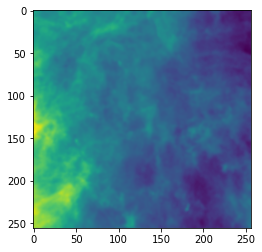

In [56]:
plt.imshow(true_test[20])

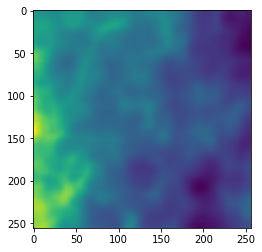

In [57]:
plt.imshow(predicted_test[20])

## Interpolated maps

In [34]:
def spherical_interpolation(z1, z2, num_samples=4):
    """ Function to interpolate between two Cartesian vectors, :math:`z1` and :math:`z2`,
    assuming a standard normal prior.
    """
    lamb = np.linspace(0, 1, num_samples)
    theta = np.dot(z1, z2) * np.pi / 180.
    return np.sin(theta * (1 - lamb[:, None])) / np.sin(theta) * z1[None, :] + np.sin(lamb[:, None] * theta) / np.sin(theta) * z2[None, :]

test_set_size = 339
num_samples = 10
np.random.seed(1234)

i1 = np.random.randint(0, test_set_size)
i2 = np.random.randint(0, test_set_size)

test_map1 = true_test[[i1]]
test_map2 = true_test[[i2]]

z_mu_i1, z_sig_i1 = model.encode(test_map1)
z_mu_i2, z_sig_i2 = model.encode(test_map2)

z_interp = spherical_interpolation(z_mu_i1[0], z_mu_i2[0], num_samples=num_samples)

decoded_interpolated_vectors = model.decode(z_interp)

semantic_sequence_dataset = np.concatenate((test_map1, decoded_interpolated_vectors, test_map2))

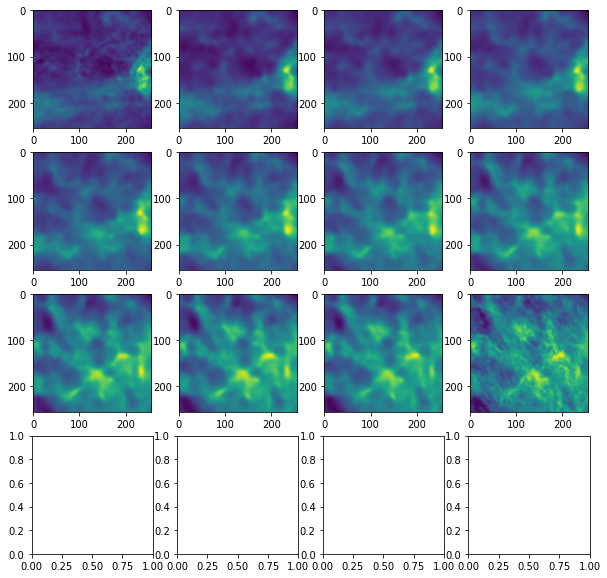

In [35]:
l = int(np.ceil(np.sqrt(num_samples)))
fig, ax = plt.subplots(l, l, figsize=(10, 10))
for i in range(num_samples+2):
    ax.flatten()[i].imshow(semantic_sequence_dataset[i, :, :, 0])

In [36]:
np.save(DIR / "semantic_sequence_dataset.npy", semantic_sequence_dataset)

## Data Imputation

In [37]:
a, b = 60, 100
n = 256
r = 50

y,x = np.ogrid[-a:n-a, -b:n-b]
mask = x*x + y*y <= r*r

array = np.ones((n, n))
array[mask] = 0
masks = []
masks.append(array)

A = np.ones((n, n))
patches = [
    ((0, 100), (0, 160)),
    ((50, 200), (150, 250)),
]
for (xinds, yinds) in patches:
    B = np.copy(A)
    B[xinds[0]: xinds[1], yinds[0]:yinds[1]] = 0
    masks.append(B)

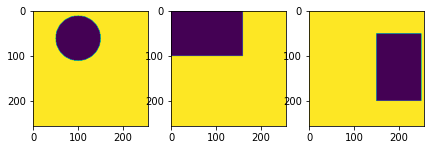

In [38]:
fig =plt.figure(figsize=(7, 3))
plt.subplot(131)
plt.imshow(masks[0])
plt.subplot(132)
plt.imshow(masks[1])
plt.subplot(133)
plt.imshow(masks[2])

In [40]:
test_maps_subset = true_test[[1, 5, 50]]
print(test_maps_subset.shape)

(3, 256, 256, 1)


In [41]:
def get_log_prob(mask, ma, sigma, retjac=True):
    assert ma.ndim==4
    def log_prob(z):
        if retjac:
            with tf.GradientTape() as tape:
                tape.watch(z)
                genned_image = model.decode(z)
                loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            jac = tape.gradient(loss_value, z)
            loss_value = tf.reshape(loss_value, [1])
            return loss_value, jac
        else:
            genned_image = model.decode(z)
            loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            return loss_value
    return log_prob

In [42]:
bin_opt = []

for mask, sub in zip(masks, test_maps_subset):
    masked = mask[None, ...].astype(int) * sub[..., 0]
    logprob = get_log_prob(mask.astype(bool), sub[None, ...], 0.01)
    x = tf.Variable(np.random.randn(1, LAT_DIM).astype(np.float32))
    bin_opt.append(tfp.optimizer.lbfgs_minimize(logprob, initial_position=x, max_iterations=200))

Instructions for updating:
Use tf.identity instead.


In [43]:
recovered = np.empty((len(bin_opt), 256, 256, 1))
recovered[0] = np.array(model.decode(bin_opt[0].position))
recovered[1] = np.array(model.decode(bin_opt[1].position))
recovered[2] = np.array(model.decode(bin_opt[2].position))
masked = np.array([mask.astype(float) * sub[..., 0] for mask, sub in zip(masks, test_maps_subset)])[..., None]

In [44]:
masked = [mask.astype(float) * sub[..., 0] for mask, sub in zip(masks, test_maps_subset)]

In [45]:
masked[0][masks[0].astype(int)==0] = np.nan
masked[1][masks[1].astype(int)==0] = np.nan
masked[2][masks[2].astype(int)==0] = np.nan
masked = np.array(masked)[..., None]

In [48]:
data_imputation_dataset = np.concatenate((test_maps_subset, masked, recovered))
print(data_imputation_dataset.shape)

(9, 256, 256, 1)


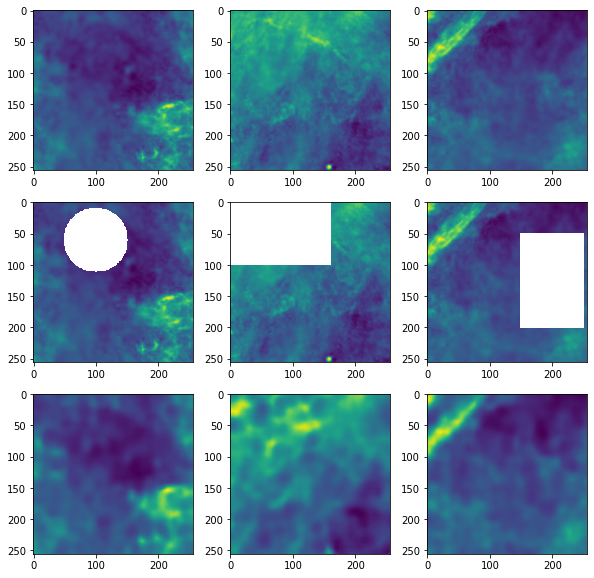

In [49]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    ax.flatten()[i].imshow(data_imputation_dataset[i, :, :, 0])

In [50]:
np.save(DIR / "data_imputation_dataset.npy", data_imputation_dataset)

In [ ]:
fig, axes = make_prediction_plot_with_residuals(x_test[:3], predicted[:3], '')
fig.savefig(PLOT_DIR / "reconstruciton_w_res.pdf", bbox_inches='tight')

In [ ]:
latent_vector = list(model.encode(x_test) for x_test in test_dataset)
test_maps = np.concatenate([x_test for x_test in test_dataset])

In [ ]:
mu, sigma = zip(*latent_vector)
latent_encoded_means = np.concatenate(mu)
latent_encoded_sigma = np.concatenate(sigma)

In [ ]:
def plot_flattened_latent_vectors(arr):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 2), dpi=150)
    ax.hist(arr, range=[-4, 4], bins=50, alpha=0.6, density=True)
    #ax.spines['left'].set_position(('outward', 10))
    #ax.spines['bottom'].set_position(('outward', 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(r"$z$")
    ax.set_ylabel(r"Frequency")
    return fig, ax

fig, ax = plot_flattened_latent_vectors(latent_encoded_means.flatten())
fig.savefig(PLOT_DIR / "latent_flat_hist.pdf", bbox_inches='tight')

In [ ]:
from scipy import stats

In [ ]:
KS = np.empty(LAT_DIM)
Pval = np.empty(LAT_DIM)
for i in range(LAT_DIM):
    KS[i] = stats.kstest(latent_encoded_means[:, i], 'norm')[0]
    Pval[i] = stats.kstest(latent_encoded_means[:, i], 'norm')[1]

In [ ]:
plt.semilogy(Pval)
plt.axhline(0.05)

In [ ]:
sum(Pval < 0.05)

In [ ]:
latent_encoded_means.shape

plt.hist(latent_encoded_means[:, 3], bins=20, range=[-3, 3])

In [ ]:
plt.hist(np.random.randn(253), bins=20, range=[-3, 3])

In [ ]:
corr = np.cov(latent_encoded_means.T)

In [ ]:
fig, ax = plt.subplots(1, 1)
img = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xlabel("$z$")
ax.set_ylabel("$z$")
plt.colorbar(img)

In [ ]:
np.dot(latent_encoded_means)

In [ ]:
model.summary()

In [ ]:
def spherical_interpolation(z1, z2, num_samples=4):
    """ Function to interpolate between two Cartesian vectors, :math:`z1` and :math:`z2`,
    assuming a standard normal prior.
    """
    lamb = np.linspace(0, 1, num_samples)
    theta = np.dot(z1, z2) * np.pi / 180.
    return np.sin(theta * (1 - lamb[:, None])) / np.sin(theta) * z1[None, :] + np.sin(lamb[:, None] * theta) / np.sin(theta) * z2[None, :]

In [ ]:
def make_semantic_sequence_plot(arr, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr.ndim == 4
    # assume only one channel
    assert arr.shape[-1] == 1
    # assume 4 samples
    assert arr.shape[0] == 6
    
    fig, axes = plt.subplots(ncols=3, nrows=2, dpi=150, figsize=(7, 4), sharex=True, sharey=True)

    kwds = {
        'extent': [-10, 10, -10, 10],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }
    axes[0, 0].imshow(arr[0, :, :, 0], **kwds)
    axes[0, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[0, 1].imshow(arr[1, :, :, 0], **kwds)
    axes[0, 2].imshow(arr[2, :, :, 0], **kwds)
    axes[1, 0].imshow(arr[3, :, :, 0], **kwds)
    axes[1, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[1, 0].set_xlabel(r"$x~{\rm [^\circ]}$")
    img = axes[1, 1].imshow(arr[4, :, :, 0], **kwds)
    axes[1, 1].set_xlabel(r"$x~{\rm [^\circ]}$")
    axes[1, 2].imshow(arr[5, :, :, 0], **kwds)
    axes[1, 2].set_xlabel(r"$x~{\rm [^\circ]}$")

    for ax in axes.flatten():
        ax.xaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.yaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        ligo.skymap.plot.outline_text(ax)

    msgs = [
        r"$\mathbf{x}_1~(\lambda=0)$",
        r"$\lambda=1/5$",
        r"$\lambda=2/5$",
        r"$\lambda=3/5$",
        r"$\lambda=4/5$",
        r"$\mathbf{x}_2~(\lambda=1)$"
    ]
    for ax, msg in zip(axes.flatten(), msgs):
        ax.annotate(msg, xy=(0.03, 0.91), xycoords='axes fraction')
        ligo.skymap.plot.outline_text(ax)
        
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

    cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_label(r"$\log{\left(I^{\rm VAE}{[\rm MJy / sr]} \right)}$")
    return fig, ax

test_set_size = 10 * BATCH_SIZE
np.random.seed(192)
i1 = np.random.randint(0, test_set_size)
i2 = np.random.randint(0, test_set_size)

test_map1 = test_maps[[i1]]
test_map2 = test_maps[[i2]]

z_mu_i1, z_sig_i1 = model.encode(test_map1)
z_mu_i2, z_sig_i2 = model.encode(test_map2)

z_interp = spherical_interpolation(z_mu_i1[0], z_mu_i2[0])

decoded_interpolated_vectors = model.decode(z_interp)

semantic_sequence = np.concatenate((test_map1, decoded_interpolated_vectors, test_map2))

fig, ax = make_semantic_sequence_plot(semantic_sequence, title="Semantic sequence")
fig.savefig(PLOT_DIR / "semantic_interpolation.pdf", bbox_inches='tight')


### Data imputation

#### Mask 

In [ ]:
def make_missing_window_plot(arr, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr.ndim == 4
    # assume only one channel
    assert arr.shape[-1] == 1
    # assume 4 samples
    assert arr.shape[0] == 9
    
    fig, axes = plt.subplots(ncols=3, nrows=3, dpi=150, figsize=(7, 6), sharex=True, sharey=True)

    kwds = {
        'extent': [-10, 10, -10, 10],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -2,
        'vmax': 2
    }
    fig.suptitle(title)
    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    
    axes[0, 0].imshow(arr[0, :, :, 0], **kwds)
    axes[0, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[0, 1].imshow(arr[1, :, :, 0], **kwds)
    axes[0, 2].imshow(arr[2, :, :, 0], **kwds)
    
    axes[1, 0].imshow(arr[3, :, :, 0], **kwds)
    axes[1, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[1, 1].imshow(arr[4, :, :, 0], **kwds)
    axes[1, 2].imshow(arr[5, :, :, 0], **kwds)
    
    axes[2, 0].imshow(arr[6, :, :, 0], **kwds)
    axes[2, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[2, 0].set_xlabel(r"$x~{\rm [^\circ]}$")
    axes[2, 1].imshow(arr[7, :, :, 0], **kwds)
    axes[2, 1].set_xlabel(r"$x~{\rm [^\circ]}$")
    img = axes[2, 2].imshow(arr[8, :, :, 0], **kwds)
    axes[2, 2].set_xlabel(r"$x~{\rm [^\circ]}$")

    for ax in axes.flatten():
        ax.xaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.yaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        ligo.skymap.plot.outline_text(ax)

    msgs = [
        r"$x_1$",
        r"$x_2$",
        r"$x_3$",
        r"$A_1 x_1 + n$",
        r"$A_2 x_2 + n$",
        r"$A_3 x_3 + n$",
        r"$g_\phi(z_1^{\rm MAP})$",
        r"$g_\phi(z_2^{\rm MAP})$",
        r"$g_\phi(z_3^{\rm MAP})$",
    ]
    for ax, msg in zip(axes.flatten(), msgs):
        ax.annotate(msg, xy=(0.03, 0.91), xycoords='axes fraction')
        ligo.skymap.plot.outline_text(ax)
        
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

    cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.set_label(r"$\log{\left(I^{\rm VAE}{[\rm MJy / sr]} \right)}$")
    return fig, ax
fig, ax = make_missing_window_plot(np.random.randn(9, 256, 256, 1), title='Data imputation')

In [ ]:
a, b = 60, 100
n = 256
r = 50

y,x = np.ogrid[-a:n-a, -b:n-b]
mask = x*x + y*y <= r*r

array = np.ones((n, n))
array[mask] = 0
masks = []
masks.append(array)

A = np.ones((n, n))
patches = [
    ((0, 100), (0, 160)),
    ((50, 200), (150, 250)),
]
for (xinds, yinds) in patches:
    B = np.copy(A)
    B[xinds[0]: xinds[1], yinds[0]:yinds[1]] = 0
    masks.append(B)

In [ ]:
fig =plt.figure(figsize=(7, 3))
plt.subplot(131)
plt.imshow(masks[0])
plt.subplot(132)
plt.imshow(masks[1])
plt.subplot(133)
plt.imshow(masks[2])

In [ ]:
import tensorflow_probability as tfp

In [ ]:
test_maps_subset = test_maps[[1, 5, 50]]
print(test_maps_subset.shape)

In [ ]:
def get_log_prob(mask, ma, sigma, retjac=True):
    assert ma.ndim==4
    def log_prob(z):
        if retjac:
            with tf.GradientTape() as tape:
                tape.watch(z)
                genned_image = model.decode(z)
                loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            jac = tape.gradient(loss_value, z)
            loss_value = tf.reshape(loss_value, [1])
            return loss_value, jac
        else:
            genned_image = model.decode(z)
            loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            return loss_value
    return log_prob

In [ ]:
bin_opt = []

for mask, sub in zip(masks, test_maps_subset):
    masked = mask[None, ...].astype(int) * sub[..., 0]
    logprob = get_log_prob(mask.astype(bool), sub[None, ...], 0.01)
    x = tf.Variable(np.random.randn(1, LAT_DIM).astype(np.float32))
    bin_opt.append(tfp.optimizer.lbfgs_minimize(logprob, initial_position=x, max_iterations=200))

In [ ]:
recovered = np.empty((len(bin_opt), 256, 256, 1))
recovered[0] = np.array(model.decode(bin_opt[0].position))
recovered[1] = np.array(model.decode(bin_opt[1].position))
recovered[2] = np.array(model.decode(bin_opt[2].position))
masked = np.array([mask.astype(float) * sub[..., 0] for mask, sub in zip(masks, test_maps_subset)])[..., None]

In [ ]:
masked = [mask.astype(float) * sub[..., 0] for mask, sub in zip(masks, test_maps_subset)]



In [ ]:
masked[0][masks[0].astype(int)==0] = np.nan
masked[1][masks[1].astype(int)==0] = np.nan
masked[2][masks[2].astype(int)==0] = np.nan
masked = np.array(masked)[..., None]

In [ ]:
masked.shape

In [ ]:
fig, ax = make_missing_window_plot(np.concatenate((test_maps_subset, masked, recovered)), title='')
fig.savefig(PLOT_DIR / "data_imputation.pdf", bbox_inches='tight')



In [16]:
mhd_arr = np.load("/global/cscratch1/sd/bthorne/ml_foregrounds/datasets/mhd/R8_4pc.npy")

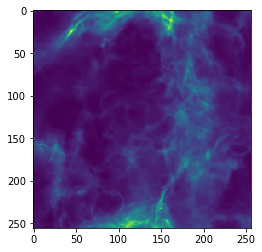

In [29]:
plt.imshow(mhd_arr[400, :, :, 0])

In [30]:
print(mhd_arr[:1, :, :, :1].shape)

(1, 256, 256, 1)


In [31]:
mhd_reconstruction = model.predict(mhd_arr[:1, :, :, :1])

In [32]:
print(mhd_reconstruction.shape)

(1, 256, 256, 1)


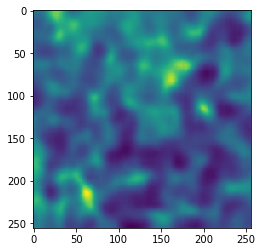

In [33]:
plt.imshow(mhd_reconstruction[0, :, :, 0])

## Novel Samples